In [1]:
import torch

张量的每一对方括号 **<u>向内</u>** 是一个维度

## 张量的赋值、索引与形状

In [ ]:
b = torch.ones(3)   # 创建大小为3的一维张量, 用1.0填充
print(b)

print(b[1])
print(float(b[1]))  # 直接索引元素得到的还是张量, 需要转化成浮点型

In [ ]:
b[2] = 2.0
print(b)
b[2] = torch.tensor(3.)
print(b)
b[2] = torch.tensor([4.])     # 把 python list 转化成张量
# ERROR: b[2] = torch.tensor([4., 5.])
print(b)

# 三种赋值方式等价

复习python列表索引

In [ ]:
some_list = list(range(6))
print(some_list[:])
print(some_list[1:4])
print(some_list[:4])
print(some_list[:-1])
print(some_list[1:5:2])   # 1到5, 左闭右开, 步长为2

In [ ]:
points = torch.tensor([[4.0, 1.0], [5.0, 2.0], [6.0, 3.0]])
print('Get shape: ', points.shape)   # 3行, 2列

print(points[0,1])   # 双索引, 0号列表里的1号元素, 从外往里数方括号

In [2]:
# 在维度里使用冒号选择符
example = torch.randn(4,5,6)
cut = example[:, 1:, :3]
cut.shape

torch.Size([4, 4, 3])

## 张量维度的命名

In [ ]:
# 给维度命名
weights_unnamed = torch.tensor([[[0.2], [0.7]], [[0.3], [0.6]]])
weights_named = torch.tensor([[[0.2], [0.7]], [[0.3], [0.6]]], names = ['channels', 'rows', None])
#print(weights_named.shape, weights_named)

# 重命名
weights_A = weights_unnamed.refine_names(..., 'cha', 'ro')
#print(weights_A.shape, weights_A)

# 移除名称
weights_unnamed = weights_A.rename(None)

# 重命名
# ERROR: weights_B = weights_named.refine_names(..., 'cha', 'ro')
weights_B = weights_named.refine_names(..., 'rows', 'columns')
print(weights_B.shape, weights_B)
weights_C = weights_B[1][0]
print(weights_C.shape, weights_C)

# 如果本来没有名称, 三点表示在末尾处赋予名称
# 如果本来有名称, 三点后的第一个字符串应当是已经存在的名称, 改名从这里开始

In [ ]:
weights_aligned = weights_C.align_as(weights_B)
print(weights_aligned.shape, weights_aligned)
weights_mul = (weights_aligned * weights_B)
print(weights_mul.shape, weights_mul)
weights_sum = weights_mul.sum('rows')
print(weights_sum.shape, weights_sum)

## 张量元素的数据类型

```
python 中数字是对象, 占用内存更多. PyTorch 和 NumPy 等库的数据结构更高效. 

对于张量构造函数, 使用 dtype 参数指定数据类型. 分为: torch.float32 / torch.float ; torch.float64 / torch.double ; torch.float16 / torch.half ; torch.int8 ; torch.uint8 ; torch.int16 / torch.short ; torch.int32 / torch.int ; torch.int64 / torch.long ; torch.bool
默认为 float32, 切换至 double 不会提高精度, 但是占用更多内存. half 只在GPU中存在, 同样没有明显精度改变, 但可以减少内存占用.
运算时如果类型不同, 会自动向较大类型转换.
```

In [ ]:
double_points = torch.ones(5, 2, dtype=torch.double)
short_points = torch.ones(7, 2, dtype=torch.short)
print(short_points.dtype)

double_points = short_points.to(torch.double)
short_points = double_points.short()

## 张量的存储

#### 存储方式概论

张量在存储空间中是一个一维的列表, 访问时根据各维度的数量来索引.可以用 torch.storage() 方法索引, 共享内存. 

假设有形状为(a,b,c)的张量T. 访问 T[0] 时, 系统会数出存储区域的前 b*c 个元素.

很多方法赋到新变量时会和原张量共享内存, 并没有创建新存储空间. 

In [ ]:
a = torch.randn(3,2)
#print(a)
b = a.unsqueeze(1)
b = a.unsqueeze_(1)  # a will change

b.zero_()      # this will cause a to be zero
print(a)

```
使用 torch.clone() 方法可以复制出一块独立的存储空间, 避免修改后的张量与原张量发生关联.
```

#### 连续性

连续张量, 是指从前往后逐个访问元素, 得到的序列等同于它实际在存储中的序列.

transpose() 等方法会使张量的连续性被破坏. 很多方法只对连续张量有效, 所以有时要调用 contiguous() 方法调整存储的顺序和索引步长, 这一过程中张量不变.

In [ ]:
points = torch.randn(3,1,5)
print(points.is_contiguous())
a = points.unsqueeze(1)
print(a.is_contiguous())
b = a.squeeze()
print(b.is_contiguous())
c = b.transpose(0,1)
print(c.is_contiguous())

print(c.storage())
d = c.contiguous()
print(d.is_contiguous(), d.storage())

#### 存储到GPU

device 是张量的一个属性.

In [ ]:
# USE MULTIPLE GPUs

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

In [ ]:
# !nvidia-smi

# three ways of init/transfer tensor in GPU/CPU.
p_gpu = torch.tensor([[4.0, 1.0], [5.0, 2.0], [6.0, 3.0]], device = 'cuda') # init
p2_gpu = torch.randn(2, 3).to(device='cuda:0')  # transfer
p3_gpu = torch.randn(2, 3).cuda()   # transfer
p3 = p3_gpu.cpu()
print(p2_gpu)

p = torch.tensor([[4.0, 1.0], [5.0, 2.0], [6.0, 3.0]])
p = 2 * p                    # this is calculated and stored in CPU
p_gpu = p_gpu * 2 + 4        # this is calculated and stored in GPU

#### 保存到文件

In [ ]:
aa = torch.randn(3,4,5)

In [ ]:
# way 1
torch.save(aa, './example.t')
bb = torch.load('./example.t')

In [ ]:
# way 2
with open('./example.t', 'wb') as f:
    torch.save(aa, f)

## 转换操作

以下划线结尾的方法, 如 zeros_(), unsqueeze_(), 会直接改变张量. 

#### 升维 UNSQUEEZE

加下划线则改变母张量. 共享内存.

```
torch.unsqueeze(
	input, 
	dim, 	     # dim 从0算起, 将要扩增的维度. 将会在这个维度之前增加一个数量为1的维度.
	out = None)
如果dim为负, 则将会被转化dim+input.dim()+1, 即从后往前数.

unsqueeze_ 和 unsqueeze 实现一样的功能, 
区别在于 unsqueeze 不会对使用 unsqueeze 的 tensor 进行改变, 想要获取 unsqueeze 后的值必须赋予个新值, 
unsqueeze_ 则会对自己改变. 
```

In [ ]:
img_t = torch.randn(3, 5, 5)        # Shape (channels, rows, columns)
print(img_t.shape, img_t)
batch_t = torch.randn(2, 3, 5, 5)   # Shape (batch, channels, rows, columns <- 这个叫作第四个维度的数量)
#print('batch_t: ',batch_t)

img_gray_naive = img_t.mean(-3)
# 消除倒数第三个维度. 假设这个维度的数量是3, 把这个维度上的每3个值叠起来用一个平均值代替. 
batch_gray_naive = batch_t.mean(-3)
print(img_gray_naive.shape)
# print(batch_gray_naive.shape, batch_gray_naive)

#### 维度清理 SQUEEZE

加下划线则改变母张量. 共享内存.

```
torch.squeeze(input, dim, out = None)
For example, if input is of shape: (A, 1, B, C, 1, D) then the out tensor will be of shape: (A, B, C, D).

When dim is given, a squeeze operation is done only in the given dimension. If input is of shape: (A, 1, B), squeeze(input, 0) leaves the tensor unchanged, but squeeze(input, 1) will squeeze the tensor to the shape (A, B).
```

In [ ]:
f = torch.randn(3, 1, 2, 1, 2)
g = f.squeeze()
g.zero_()
print(f)

#### 维度转置 TRANSPOSE

只改变索引机制. 共享内存.

```
回顾访问方式: 假设有形状为(a,b,c)的张量T. 访问 T[0] 时, 系统会数出存储区域的前 b*c 个元素.

维度转置, 是交换两个维度的数量, 而不移动元素.
```

In [ ]:
# 简单二维转置 torch.t() 相当于把行列互换

c = torch.tensor([[4.0, 1.0], [5.0, 2.0], [6.0, 3.0]])
print(c.storage(), c)
d = c.t()
d[0,0] = 0.0
print(d.storage(), d)
print(c.storage(), c)       # no change

In [ ]:
# 多维转置

a = torch.tensor([[[1, 2, 3], [4, 5, 6]]])
print(a.shape)
b = a.transpose(0, 2)
print(b.shape, b)
print((a[0,1,1] == b[1,1,0]))

#### 维度重排 PERMUTE
和 transpose 类似, 但可以直接指定维度顺序.

In [ ]:
a = torch.tensor([[[2, 3], [4, 5]], [[6, 7], [8, 9]]])
b = a.permute(0,2,1)
print((a[0,1,0] == b[0,0,1]))

#### 按索引抽取 GATHER 和 按索引填入 SCATTER
```
scatter为“填入”. data.scatter(dim,index,src) 就是把src这个张量按照index张量规定的规则塞到data中.

假设dim=0. 机器每读取一个index的long型序号数值x(位于index的(i,j,k)), 就接着索引到src的数值y(位于(i,j,k)), 把得到的值y填入data的(x,j,k).

假设dim=1. 机器每读取一个index的long型序号数值x(位于index的(i,j,k)), 就接着索引到src的数值y(位于(i,j,k)), 把得到的值y填入data的(i,x,k).
```

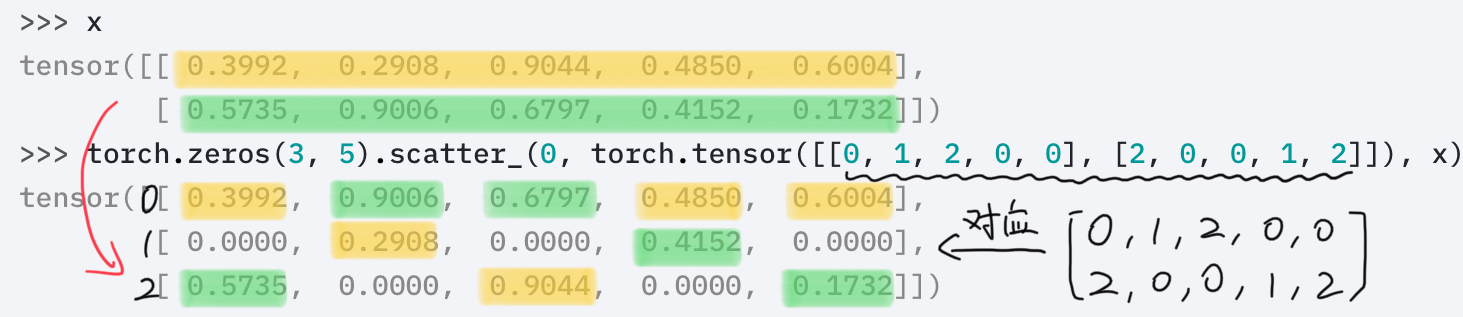

In [3]:
from PIL import Image
Image.open('./pngs/v2-r.jpg')

## 逐点操作

#### 维度求和 SUM

```
torch.sum(input)
打开所有维度, 把所有数求和, 输出单元素张量.

torch.sum(input, dim, keepdim = False)
把指定维度求和. keepdim = False 时对这个维度上的元素求和, 并消除这个维度, keepdim = True 时会保留这个维度.
```

In [ ]:
k = torch.tensor([[[1], [2]], [[3], [4]]])
print(k)
j = k.sum()
print(j)
#j = k.squeeze(1)
j = k.sum(0)
print(j)
j = k.sum(0, keepdim = True)
print(j)

In [ ]:
a = torch.randn(3, 2)
b = a.sum(1)
b.zero_()
print(a)

#### 点乘
```
张量点乘, 对于某个维度:
若数量都不是1, 则必须数量相等才能相乘, 计算方法是: i位对i位相乘
若数量有一个是1, 则可以相乘, 计算方法是: 多数量的每一个值分别去乘单数量的值, 类似乘法分配律
```

In [ ]:
img_t = torch.randn(3, 5, 5)
batch_t = torch.randn(2, 3, 5, 5)
weights = torch.tensor([0.2126, 0.7152, 0.0722])
# 一般对维度数相同的张量进行乘法运算, 可能需要提前对张量进行升维/降维. 若维度不同, 会自动在较短张量最外面补一维.

unsqueezed_weights = weights.unsqueeze(-1).unsqueeze_(-1)  # 在最后(即最小维度)升两维
print(unsqueezed_weights.shape, unsqueezed_weights)

img_weights = (img_t * unsqueezed_weights)
batch_weights = (batch_t * unsqueezed_weights)
print(img_weights.shape, batch_t.shape, batch_weights.shape)
img_gray_weighted = img_weights.sum(-3)     # 相当于squeeze
batch_gray_weighted = batch_weights.sum(-3)
print(img_weights.shape, img_gray_weighted.shape)
#batch_weights.shape, batch_t.shape, unsqueezed_weights.shape

In [ ]:
# tensor multiplication test

def mult(A, B):
    print(A, '<TIMES>', B, ' = ', A * B)

x = torch.tensor([3, 5, 7, 9])
# ERROR: x = torch.tensor([3, 5, 7])
y = torch.tensor([13, 17, 19, 23])
mult(x, y)

x = torch.tensor([3])
y = torch.tensor([13, 17, 19, 23])
mult(x, y)

x = torch.tensor([[3]])
x = torch.tensor([[3], [27]])
# ERROR: x = torch.tensor([[3], [27], [99]])
y = torch.tensor([[13, 17, 19, 23], [1, 5, 7, 11]])
mult(x, y)

x = torch.tensor([[3, 4, 1, 2], [5, 6, 7, 8]])
y = torch.tensor([[10, 11, 12, 13], [14, 15, 16, 17]])
mult(x, y)